# Extracting Graphs From Outputs
So what we want to do is create 



In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

# Creating the Graph for 167S, THNB

In [2]:
COST_CANCEL_OUT = 1000
FILENAME_PREFIX = './RunOutput-2022-08-18-00-02-43/MODELOUT_ObjectiveFile_VaryingCost_0802022_'
FILENAME_SUFFIX = '_decision_vars.csv'

df_allrun_costs = pd.read_csv('./RunCosts_AllRuns.csv').drop(columns=['Unnamed: 0', 'Year'])

In [3]:


df_167s_thnb = df_allrun_costs[df_allrun_costs['StandID'] == '167S']

# Filter out runs where this management has a cost of 1000
df_167s_only_thnb = df_167s_thnb[df_167s_thnb['MgmtID'] == 'THNB']
filter_runs = df_167s_only_thnb[df_167s_only_thnb['Mgmt_Cost'] != COST_CANCEL_OUT]
filter_runs = filter_runs.drop(columns=['Mgmt_Cost', 'MgmtID', 'StandID'])
df_167s_thnb = df_167s_thnb.merge(filter_runs, how='right', on=['Run'])

# Now we have costs only for the runs where this is the cheap management
df_167s_thnb

,Run,StandID,MgmtID,Mgmt_Cost
0,0,167S,PLSQ,0.000000
1,0,167S,THNB,-1.000000
2,1,167S,PLSQ,0.000000
3,1,167S,THNB,-0.972431
4,2,167S,PLSQ,0.000000
...,...,...,...,...
795,397,167S,THNB,9.944862
796,398,167S,PLSQ,0.000000
797,398,167S,THNB,9.972431
798,399,167S,PLSQ,0.000000


In [4]:
# Extract parallel lists of run and management cost
# run # is needed for processing
# mng cost is x-axis of graph

run_nums = filter_runs['Run'].tolist()
run_costs = df_167s_thnb[df_167s_thnb['MgmtID'] == 'THNB']['Mgmt_Cost'].tolist()

In [5]:
# Extract decision variables
# I'm going to do this in a horrible way for memory
# For each forest type, for each mng, I read all the output csvs
# and save just the important info :/

# key = mgmt
# value = list of acerages
run_amounts = {}

ind = 0

for run in run_nums:
    csv_name = FILENAME_PREFIX + str(run) + FILENAME_SUFFIX
    
    df = pd.read_csv(csv_name).rename(columns={
        'tag_1': 'StandID',
        'tag_2': 'Year',
        'tag_3': 'MgmtID'
    })
    df = df[df['StandID'] == '167S']
    agg_types = {
        'StandID': 'first',
        'MgmtID': 'first',
        'value': 'sum',
        'Year': 'first'
    }
    df = df.groupby(df['MgmtID']).aggregate(agg_types)

    mngs = df['MgmtID'].tolist()
    for m in mngs:
        if not m in run_amounts.keys():
            run_amounts[m] = []
        
        amnt = df[df['MgmtID'] == m]['value'].tolist()[0]
        run_amounts[m].append(amnt)
    
#     ind += 1
#     if ind >= 3:
#         break


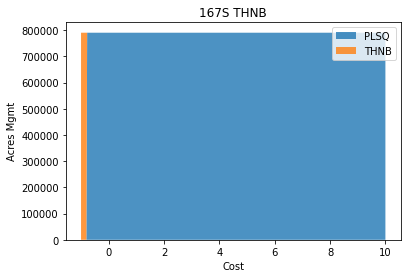

In [6]:
# Graph example
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/stackplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-stackplot-demo-py

plt.rcParams['figure.figsize'] = [12, 4]

fig, ax = plt.subplots()
ax.stackplot(run_costs, run_amounts.values(),
             labels=run_amounts.keys(), alpha=0.8)
ax.legend(loc='upper right')
ax.set_title('167S THNB')
ax.set_xlabel('Cost')
ax.set_ylabel('Acres Mgmt')

plt.show()


# Systemetizing the Previous Section into Function Calls

In [7]:
def get_relevant_runs (_df_allcosts, standID, mng):
    _df_filt = _df_allcosts[_df_allcosts['StandID'] == standID]
    
    # Filter out runs where this management has a cost of 1000
    _df_filt_mng = _df_filt[_df_filt['MgmtID'] == mng]
    _run_filter = _df_filt_mng[_df_filt_mng['Mgmt_Cost'] != COST_CANCEL_OUT]
    _run_filter = _run_filter.drop(columns=['Mgmt_Cost', 'MgmtID', 'StandID'])
    
    _df_filt = _df_filt.merge(_run_filter, how='right', on=['Run'])
    return _df_filt

# Now we have costs only for the runs where this is the cheap management
df_999_awr = get_relevant_runs(df_allrun_costs, '999', 'AWR')
df_999_awr

,Run,StandID,MgmtID,Mgmt_Cost
0,0,999,PLSQ,0.0
1,0,999,AWR,-1.0
2,0,999,CAR,1000.0
3,0,999,NAR,1000.0
4,0,999,SAR,1000.0
...,...,...,...,...
495,99,999,PLSQ,0.0
496,99,999,AWR,10.0
497,99,999,CAR,1000.0
498,99,999,NAR,1000.0


In [19]:
def get_run_nums (_df_relevant_runs):
    return list(set(_df_relevant_runs['Run'].tolist()))


def get_run_costs (_df_relevant_runs, mng):
    return _df_relevant_runs[_df_relevant_runs['MgmtID'] == mng]['Mgmt_Cost'].tolist()


def get_data_dict (run_nums, standID, only2021:bool=False):
    run_amounts = {}

    for run in run_nums:
        csv_name = FILENAME_PREFIX + str(run) + FILENAME_SUFFIX

        df = pd.read_csv(csv_name).rename(columns={
            'tag_1': 'StandID',
            'tag_2': 'Year',
            'tag_3': 'MgmtID'
        })
        df = df[df['StandID'] == standID]
        if only2021:
            df = df[df['Year'] == 2021]
        agg_types = {
            'StandID': 'first',
            'MgmtID': 'first',
            'value': 'sum',
            'Year': 'first'
        }
        df = df.groupby(df['MgmtID']).aggregate(agg_types)

        mngs = df['MgmtID'].tolist()
        for m in mngs:
            if not m in run_amounts.keys():
                run_amounts[m] = []

            amnt = df[df['MgmtID'] == m]['value'].tolist()[0]
            run_amounts[m].append(amnt)
    
    return run_amounts

runs = get_run_nums(df_999_awr)
costs = get_run_costs(df_999_awr, 'AWR')
data_dict = get_data_dict(runs, '999', True)

# costs
data_dict

{'AWR': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'CAR': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

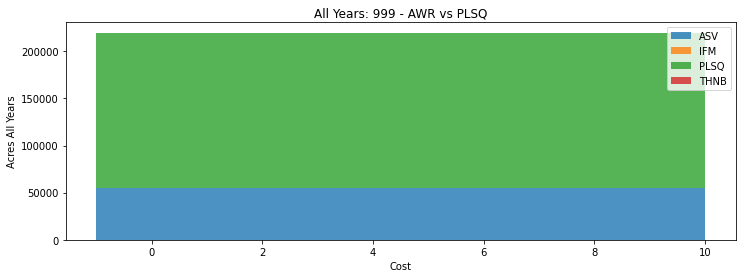

In [14]:
def make_plot (run_costs, run_amounts, mng, standID, ylabel, title):
    plt.rcParams['figure.figsize'] = [12, 4]

    fig, ax = plt.subplots()
    ax.stackplot(run_costs, run_amounts.values(),
                 labels=run_amounts.keys(), alpha=0.8)
    ax.legend(loc='upper right')
    ax.set_title(f'{title}: {standID} - {mng} vs PLSQ')
    ax.set_xlabel('Cost')
    ax.set_ylabel(ylabel)

    plt.show()

make_plot(costs, data_dict, 'AWR', '999', 'Acres All Years', 'All Years')

# Running it for Everything

In [10]:
# Create a list of mng and fortypes
df_stand_mng_pairs = df_allrun_costs[df_allrun_costs['Run'] == 0].drop(columns=['Run', 'Mgmt_Cost'])
df_stand_mng_pairs = df_stand_mng_pairs[df_stand_mng_pairs['MgmtID'] != 'PLSQ']

mngs = df_stand_mng_pairs['MgmtID'].tolist()
standIDs = df_stand_mng_pairs['StandID'].tolist()

pairs = [list(x) for x in zip(mngs, standIDs)]

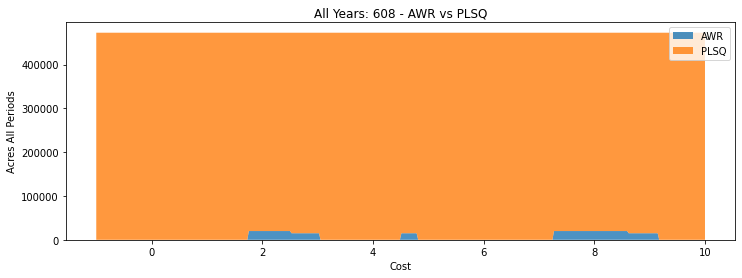

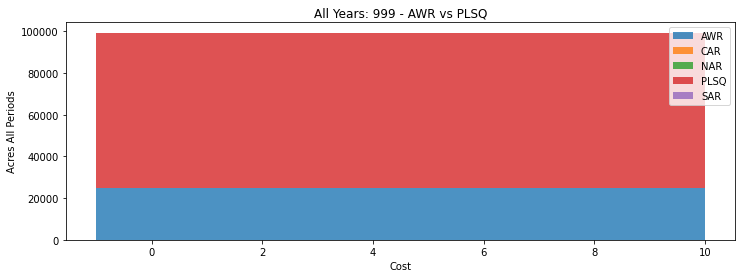

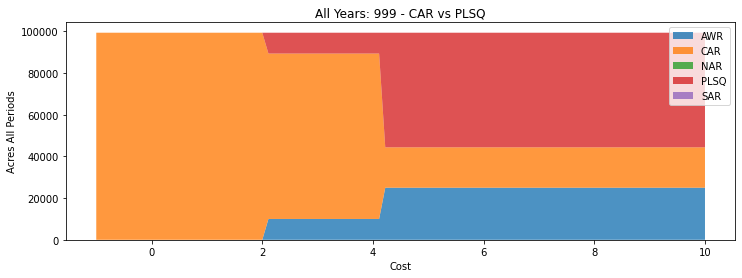

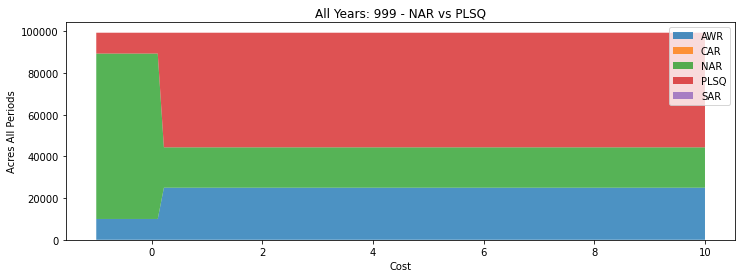

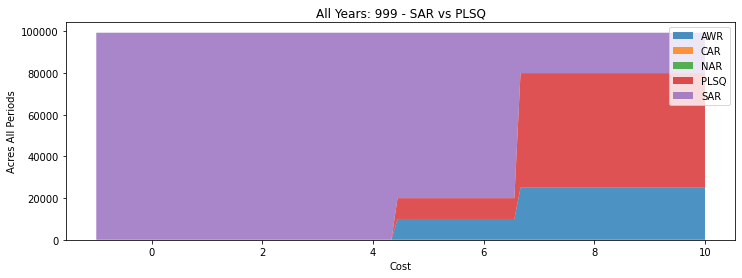

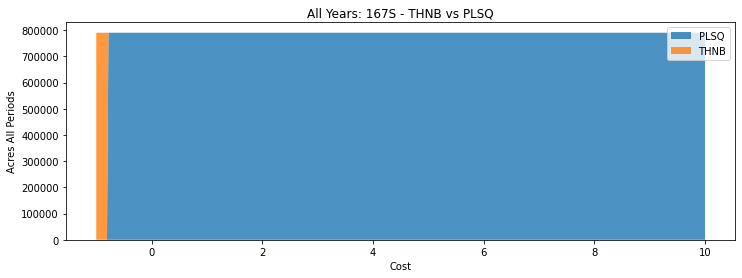

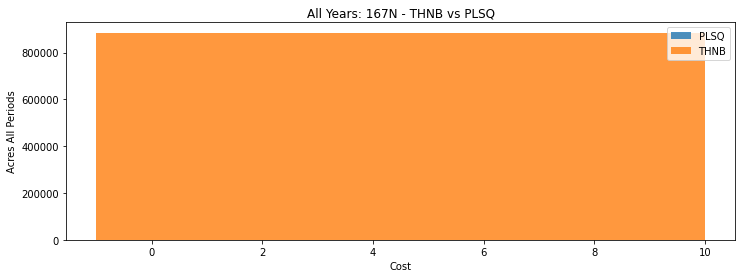

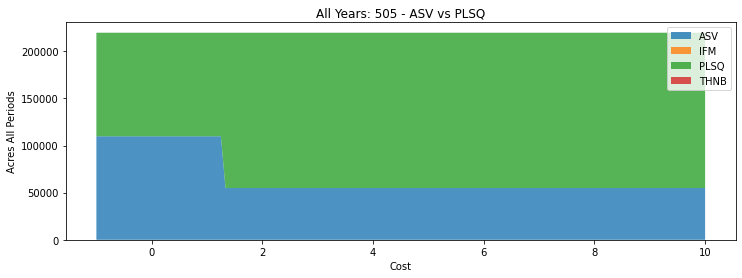

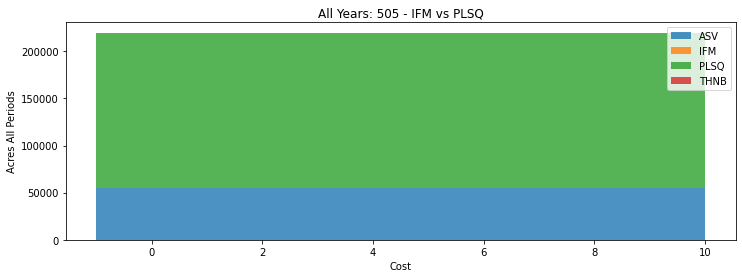

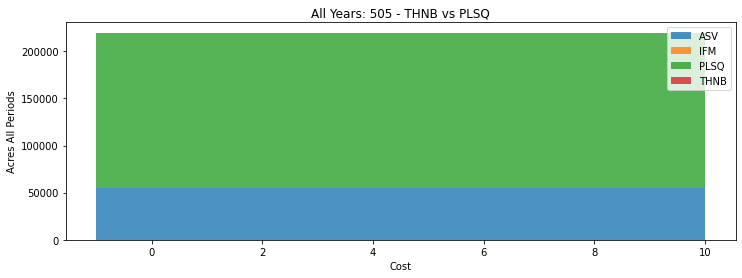

In [15]:
for pair in pairs:
    _mng = pair[0]
    _stand = pair[1]
    
    df_stand_mng = get_relevant_runs(df_allrun_costs, _stand, _mng)
    
    runs = get_run_nums(df_stand_mng)
    costs = get_run_costs(df_stand_mng, str(_mng))
    data_dict = get_data_dict(runs, _stand)
    
    make_plot(costs, data_dict, _mng, _stand, 'Acres All Periods', 'All Years')

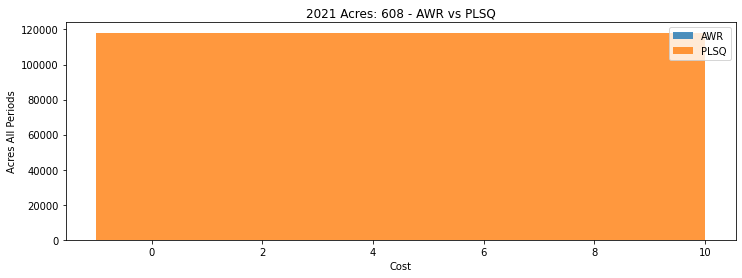

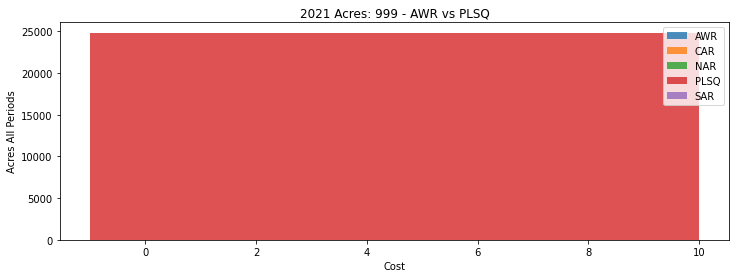

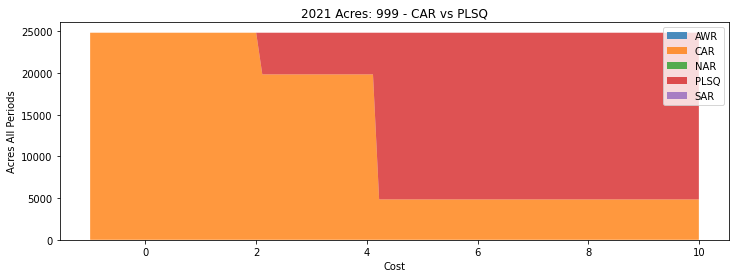

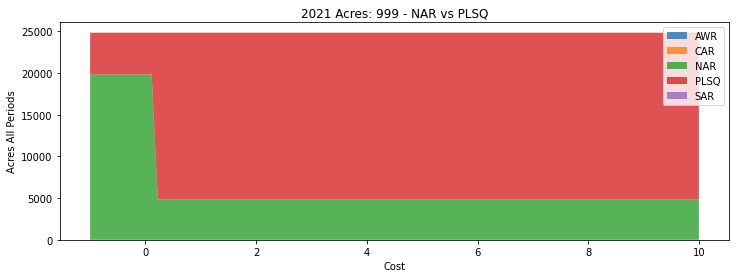

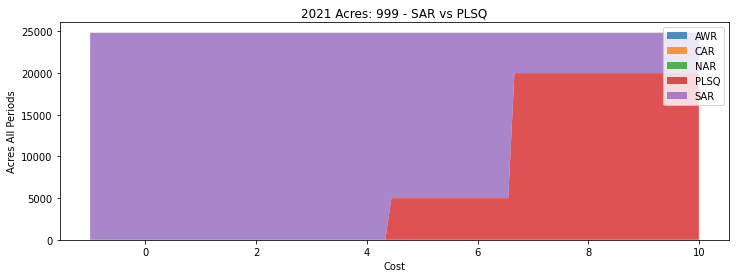

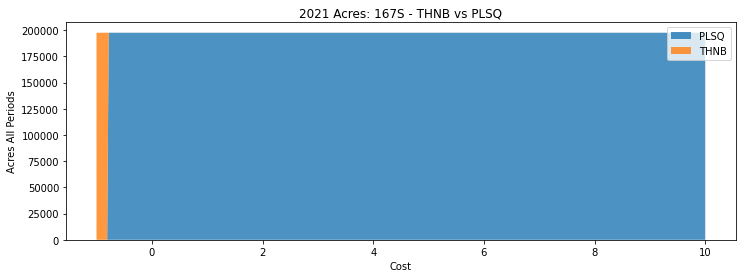

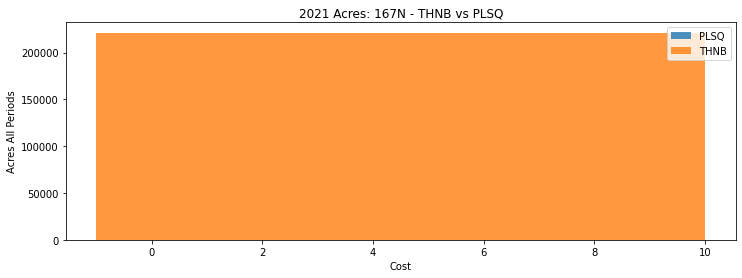

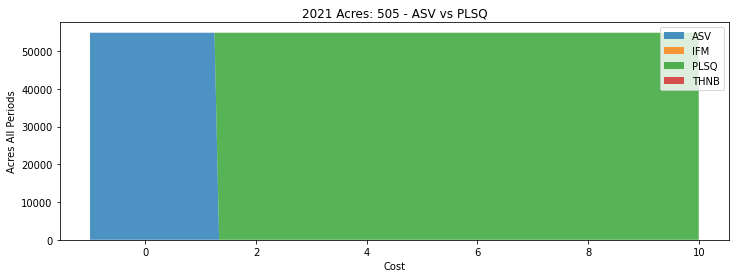

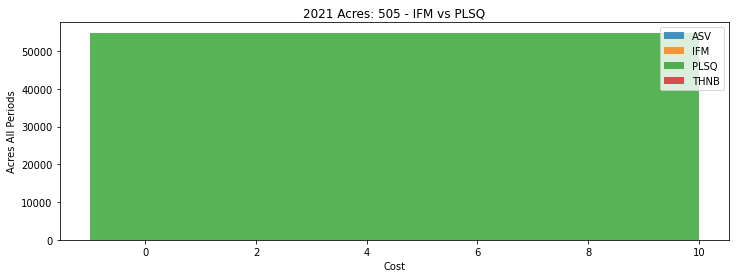

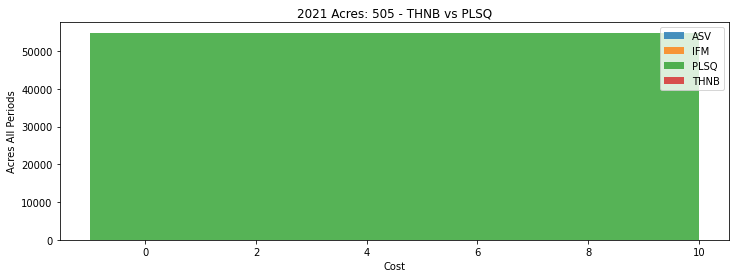

In [20]:
for pair in pairs:
    _mng = pair[0]
    _stand = pair[1]
    
    df_stand_mng = get_relevant_runs(df_allrun_costs, _stand, _mng)
    
    runs = get_run_nums(df_stand_mng)
    costs = get_run_costs(df_stand_mng, str(_mng))
    data_dict = get_data_dict(runs, _stand, only2021=True)
    
    make_plot(costs, data_dict, _mng, _stand, 'Acres All Periods', '2021 Acres')